# Fitting Gaussian Mixture on a data sample using features from a pre-trained Model using Frank-Wolfe Optimizer and sliced Frechet Divergence 

Consider the set of all $K$-dimensional categorical distributions given by

$$\begin{equation}
    \mathcal{C} = \bigg\{ \mathbf{c} \in \mathbb{R}^{K}_{+} :  \mathbf{c} \geq 0,\ \mathbf{c}^{\rm T}\mathbf{1} = 1 \bigg\} \subset \mathbb{R}^{K}_{+}.
\end{equation}
$$
In this code we consider the set of gaussian mixtures for the set of distributions $\{ \nu_{i} \}_{i = 1}^{K} $ given by given by:
$$\begin{equation}
		\mathcal{GM} \bigg(\mathbf{c}, \{ \nu_{i} \}_{i = 1}^{K} \bigg) = \bigg\{ \sum_{i = 1}^{K} c_{i} \nu_{i}, \ \forall \mathbf{c} \in \mathcal{C} \bigg\}
	\end{equation}
$$
For the mixture of gaussian distributions $\{ \nu_{i} \}_{i = 1}^{K} $ with means $\{ \mu_{i} \}_{i = 1}^{K} $ and covariance matrices $\{ \Sigma_{i} \}_{i = 1}^{K} $, mixture means and covariance are

$$
\begin{gather*}
 \bar{\mu}_{\mathbf{c}} = \sum_{k =1}^{K} c_{k} \mu_{k}\  \text{,  }
 \,\,\,\, \tilde{\Sigma}_{\mathbf{c}} = \sum_{k =1}^{K} c_k \big( \Sigma_k + \mu_{k} \mu_{k}^{\top} - \bar{\mu}_{\mathbf{c}} \bar{\mu}_{\mathbf{c}}^\top \big)
\end{gather*}
$$
For a data sample $\nu_{*}$, we employed Frank-Wolfe Based optimization routine to find the best matching mean, covaraince pair from the the set of all possible mixtures of $\{ \nu_{i} \}_{i = 1}^{K} $ to fit with mean $\mu_{*}$ and covaraince $\Sigma_{*}$ of $\nu_{*}$.

In [4]:
#%%
import numpy as np
import scipy as sp
from scipy.optimize import check_grad
from scipy.optimize import approx_fprime
from matplotlib import pyplot as plt

'''
    mx: mean of source with size: n x 1
    M: means of target distributions with size: n x K, where K indicates number of data-classes.
    covx: covariance matrix of source with size: n x 1
    covM: array of covariance matrices of target distributions with size: K x n x n, where K indicates number of data-classes.
    max_iter: max_iterations of Frank Wolfe
    tol: tolerance for gradient check
    divg: divergences to be used for computations
    max_iter: maximum of frank wolfe iterations
    min_tol: minimum tolerance for gardient checking
    print_iter: priniting values of maixture weights for each iteration
'''
class GM_FW_sliced:
    def __init__(self, mux, M, covx, covM, c0, eta, n_slice, max_iter = None, min_tol = None, print_iter = None):
        # instance attributes which should be initilzied with class
        self.mux = mux
        self.M = M
        self.covx = covx
        self.covM = covM
        self.c0 = c0
        self.w = np.zeros([mux.shape[0],1])
        self.I = np.identity(np.size(mux), dtype=np.float64)
        self.n_slice = n_slice

        # attributes to be keep track of computations
        self.c = np.zeros_like(c0, dtype=np.float64)
        self.mubar = np.zeros_like(mux, dtype=np.float64)
        self.hat_covM = self.covM + self.M.T.reshape([self.M.shape[1], self.M.shape[0], 1]) @ self.M.T.reshape([M.shape[1], 1, M.shape[0]])
        self.tilde_covM = np.zeros_like(covM, dtype=np.float64)
        self.tilde_sigma_c = np.zeros([covM.shape[1], covM.shape[2]],dtype=np.float64)
        self.zeta_c = 0
        
        if max_iter == None:
            self.max_iter = 1000
        else:
            self.max_iter = max_iter

        if min_tol == None:
            self.min_tol = 1e-6
        else:
            self.min_tol = min_tol
        
        if print_iter == None:
            self.print_iter = False
        elif print_iter == False:
            self.print_iter = False
        elif print_iter == True:
            self.print_iter = True
        else:
            self.print_iter = False

        self.obj_vals = np.zeros([self.max_iter], dtype=np.float64)
        self.grads = np.zeros([self.max_iter, np.size(self.c)], dtype=np.float64)
        self.weights = np.zeros([self.max_iter, np.size(self.c)], dtype=np.float64)
        self.eta = eta
        
    # Method to reset values of variables for new run
    def reset_values(self):
        self.I = np.identity(np.size(self.mux))
        self.w = np.zeros([mux.shape[0], 1])

        # attributes to be keep track of computations
        self.c = np.zeros_like(self.c0)
        self.mubar = np.zeros_like(self.mux)
        self.hat_covM = self.covM + \
            self.M.T.reshape([self.M.shape[1], self.M.shape[0], 1]
                         ) @ self.M.T.reshape([self.M.shape[1], 1, self.M.shape[0]])
        self.tilde_covM = np.zeros_like(self.covM)
        self.tilde_sigma_c = np.zeros([self.covM.shape[1], self.covM.shape[2]])
        self.zeta_c = np.zeros([self.covM.shape[1], self.covM.shape[2]])

        self.obj_vals = np.zeros([self.max_iter])
        self.grads = np.zeros([self.max_iter, np.size(self.c)])
        self.weights = np.zeros([self.max_iter, np.size(self.c)])
        
    # Weight initialization method to to start Frank-Wolfe Algorithm
    def initialize_weights(self):
        self.c = self.c0
    # Method to update bar{\mu} = Mc
    def update_mubar(self):
        self.mubar =  np.sum(self.c[np.newaxis,:] * self.M, axis = 1, keepdims = True)
    # Sliced MMD objective function
    def compute_mmd_sliced(self):
        return (self.w.T@(self.M @ self.c[:,np.newaxis] - self.mux))**2
    # Sliced MMD gradient
    def compute_mmd_grad_sliced(self):
        temp = self.M.T @ self.w * \
            (self.w.T@(self.M @ self.c[:, np.newaxis] - self.mux))
        return np.squeeze(temp)
    # Method to compute \tilde{\Sigma_{k}} = \Sigma_{k} + \mu_{k}\mu_{k}^{T} - \bar{\mu} \bar{\mu}^{T}
    def update_tilde_covM(self):
        self.tilde_covM = self.hat_covM - (self.mubar@self.mubar.T)[np.newaxis,:,:]
    # Method to compute \tilde{\Sigma_{\mathbf{c}}} = \sum_{c} \tilde{\Sigma_{c}}
    def update_tilde_sigma_c(self):
        self.tilde_sigma_c = np.sum(
            self.c[:, np.newaxis, np.newaxis] * self.tilde_covM, axis=0)
    # Method to compute the regularized last part of bures objective, 
    # which is used both in bures objective and its gradient
    # sqrt ( (w.T @ tilde_sigma_c @ w) * (w.T @ covx @ w) + eta^ /4 )
    # This part of the slicing comes from Austin's unpublished paper
    def update_zeta_c(self):
        temp = np.sqrt((self.w.T @ self.tilde_sigma_c @ self.w) * (self.w.T @ self.covx @ self.w) + self.eta**4/4)
        temp = np.real(temp)
        self.zeta_c = temp.item()
   # Regularized and unregulrized sliced Bures objetives
    def compute_bures_sliced(self):
        if self.eta == 0:
            return self.w.T @ ((self.tilde_sigma_c + self.covx) @ self.w) - 2 * self.zeta_c
        else:
            B = self.w.T @ ((self.tilde_sigma_c + self.covx) @ self.w) - 2 * self.zeta_c
            B = B + self.eta**2 * np.log(2 * self.zeta_c + self.eta**2) 
            B = B + self.covx.shape[0] * self.eta**2 * (1  - np.log(2*self.eta**2))
            return B

    # Bures Gradient with respect to \mathbf{c}
    def compute_bures_grad_c_sliced(self):
        G = 1 - ((self.w.T @ self.covx @ self.w) / self.zeta_c ) * (1 - self.eta**2/(2*self.zeta_c + self.eta**2))
        rho = (self.M.T.reshape(self.M.shape[1], self.M.shape[0], 1) @ self.mubar.T) + \
            self.mubar @ self.M.T.reshape(self.M.shape[1], 1, self. M.shape[0])

        # Grad = np.zeros_like(self.c0)
        # for k in range(0, Grad.size):
        #     Grad[k] = G * (self.w.T @ (self.hat_covM[k,:,:] - rho[k, :, :]) @ self.w)
        #     print(self.hat_covM[k, :, :] - rho[k, :, :])
        # above loop is replaced by the equivalent statement below
        Grad = np.squeeze( G * (self.w.T@(self.hat_covM - rho)@self.w) )
        return Grad

    # Frechet Objective as sum of bures and MMD objectives
    def compute_frechet_sliced(self):
        B = self.compute_bures_sliced()
        mmd = self.compute_mmd_sliced()
        return B + mmd
    # Frechet gradient as sum of bures and MMD gradients
    def compute_frechet_grad_sliced(self):
        GB = self.compute_bures_grad_c_sliced()
        Gmmd = self.compute_mmd_grad_sliced()
        return GB + Gmmd
    
    # Frank Wolfe Routine for Frechet
    def FW_frechet_routine(self):
        self.initialize_weights()
        if self.print_iter == True:
            print("initially")
            print(self.c)
        obj_slice = np.zeros(self.n_slice)
        grad_slice = np.zeros([self.c0.size, self.n_slice])
        W = np.random.normal(0, 1, [self.covx.shape[0], self.n_slice])
        norm_W = np.linalg.norm(W, axis=0)
        W = W / norm_W[np.newaxis, :]

        for i in range(0, self.max_iter):
            self.update_mubar()
            self.update_tilde_covM()
            self.update_tilde_sigma_c()

            for j in range(0, self.n_slice):
                self.w = W[:, j][:, np.newaxis]
                self.update_zeta_c()
                obj_slice[j] = self.compute_frechet_sliced()
                grad_slice[:, j] = self.compute_frechet_grad_sliced()

            self.obj_vals[i] = np.mean(obj_slice)
            self.grads[i, :] = np.mean(grad_slice, axis=1)
            g = self.grads[i, :]
            #print(g)
            s = np.zeros_like(self.c)
            idx = np.argmin(g)
            s[idx] = 1
            gamma = 2 / (2 + i)
            self.c = (1 - gamma) * self.c + gamma * s

            self.weights[i, :] = self.c

            if self.print_iter == True:
                print("iter = ", i)
                print(self.c)
    
    # Frank Wolfe Routine for Bures
    def FW_bures_routine_sliced(self):
        self.initialize_weights()
        if self.print_iter == True:
            print("initially")
            print(self.c)
        obj_slice = np.zeros(self.n_slice)
        grad_slice = np.zeros([self.c0.size, self.n_slice])
        W = np.random.normal(0, 1, [self.covx.shape[0], self.n_slice])
        norm_W = np.linalg.norm(W, axis=0)
        W = W / norm_W[np.newaxis, :]

        for i in range(0, self.max_iter):
            self.update_mubar()
            self.update_tilde_covM()
            self.update_tilde_sigma_c()

            for j in range(0, self.n_slice):
                self.w = W[:, j][:, np.newaxis]
                #print(self.w)
                self.update_zeta_c()
                # print(self.zeta_c)
                obj_slice[j] = self.compute_bures_sliced()
                # print(obj_slice[j])
                grad_slice[:, j] = self.compute_bures_grad_c_sliced()
                #print(grad_slice[:,j])

            self.obj_vals[i] = np.mean(obj_slice)
            self.grads[i, :] = np.mean(grad_slice, axis=1)
            g = self.grads[i, :]
            #print(g)
            s = np.zeros_like(self.c)
            idx = np.argmin(g)
            s[idx] = 1
            gamma = 2 / (2 + i)
            self.c = (1 - gamma) * self.c + gamma * s
     
            self.weights[i, :] = self.c

            if self.print_iter == True:
                print("iter = ", i)
                print(self.c)
            
    # Frank Wolfe Routine for MMD
    def FW_MMD_routine_sliced(self):
        self.initialize_weights()
        if self.print_iter == True:
            print("initially")
            print(self.c)
        obj_slice = np.zeros(self.n_slice)
        grad_slice = np.zeros([self.c0.size, self.n_slice])
        W = np.random.normal(0, 1, [self.covx.shape[0], self.n_slice])
        norm_W = np.linalg.norm(W, axis=0)
        W = W / norm_W[np.newaxis, :]
        
        for i in range(0, self.max_iter):
            for j in range(0, self.n_slice):
                self.w = W[:,j][:, np.newaxis]
                obj_slice[j] = self.compute_mmd_sliced()
                grad_slice[:,j] = self.compute_mmd_grad_sliced()
            
            self.obj_vals[i] = np.mean(obj_slice)
            self.grads[i, :] = np.mean(grad_slice, axis=1)
            g = self.grads[i,:]
            s = np.zeros_like(self.c)
            idx = np.argmin(g)
            s[idx] = 1
            gamma = 2 / (2 + i)
            self.c = (1 - gamma) * self.c  + gamma * s 
            self.grads[i,:] = np.squeeze(g)
            self.weights[i,:] = self.c

            if self.print_iter == True:
                print("iter = ",i)
                print(self.c)


def Hellinger(p, q):
  '''
  Function to evaluate Hellinger Distance between distributions categorical distributions p and q
  input: distributions p and q
  outputs: Hillnger distance between p and q

  '''
  assert np.all(p >= 0), "first distribution must be non-negative"
  assert np.all(q >= 0), "second distribution must be non-negative"
  assert p.size == q.size, "input vectors must be of same size"

  p = p.reshape([p.size, 1])
  q = q.reshape([q.size, 1])

  return (1/np.sqrt(2)) * np.linalg.norm(np.sqrt(p) - np.sqrt(q))


In [92]:
import numpy as np
import scipy as sp

M = np.array([[0, -5, 5],[10, 0, 0]])
#M = np.array([[0, 0, 0], [0, 0, 0]])
#M = np.ones_like(M)
#mux = np.array([[np.sqrt(3)/2], [np.sqrt(3)/2] ])
#mux = np.array([[0], [0] ])
#covx = np.array([[10,6],[6,8]])
covM = np.zeros([3,2,2])
covM[0] = np.array([[1, 0.5],[0.5, 1]])
covM[1] = np.array([[5, 0.6], [0.6, 7]])
covM[2] = np.array([[4, 1], [1, 2]])

mux = np.mean(M, axis = 1, keepdims = True)
#mux = np.array([[0], [10] ])
covx = 1/3 * covM[0] + 1/3 * covM[1] + 1/3 * covM[2]

#covx = np.array([[4, 1], [1, 2]])
c0 = np.ones(3)/3
#c0 = np.array([0,1/2,1/2])

iterations = 100
#(self, mux, M, covx, covM, c0, eta, n_slice, max_iter=None, min_tol=None, print_iter=None)
test = GM_FW_sliced(mux, M, covx, covM, c0, eta = 0e-1, n_slice = 100, max_iter = iterations, print_iter = False)
test.reset_values()
#test.FW_MMD_routine_sliced()
test.FW_frechet_routine()
#test.FW_bures_routine_sliced()
#test.reset_values()



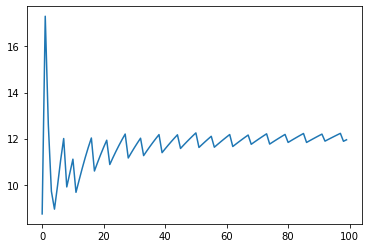

In [93]:
plt.plot(test.obj_vals)

In [95]:
test.weights

array([[0.        , 0.        , 1.        ],
       [0.66666667, 0.        , 0.33333333],
       [0.33333333, 0.5       , 0.16666667],
       [0.2       , 0.3       , 0.5       ],
       [0.13333333, 0.2       , 0.66666667],
       [0.0952381 , 0.14285714, 0.76190476],
       [0.07142857, 0.10714286, 0.82142857],
       [0.27777778, 0.08333333, 0.63888889],
       [0.22222222, 0.06666667, 0.71111111],
       [0.18181818, 0.05454545, 0.76363636],
       [0.15151515, 0.21212121, 0.63636364],
       [0.12820513, 0.17948718, 0.69230769],
       [0.10989011, 0.15384615, 0.73626374],
       [0.0952381 , 0.13333333, 0.77142857],
       [0.08333333, 0.11666667, 0.8       ],
       [0.07352941, 0.10294118, 0.82352941],
       [0.17647059, 0.09150327, 0.73202614],
       [0.15789474, 0.08187135, 0.76023392],
       [0.14210526, 0.07368421, 0.78421053],
       [0.12857143, 0.06666667, 0.8047619 ],
       [0.11688312, 0.06060606, 0.82251082],
       [0.10671937, 0.14229249, 0.75098814],
       [0.

In [55]:
test.c

array([0.12380952, 0.14285714, 0.73333333])

In [77]:
y

array([0.40213876, 0.44618199, 0.4782447 , 0.51049304, 0.43460383])

In [77]:
self.covM

NameError: name 'self' is not defined

In [210]:
W = np.random.normal(0,1,[100,2])
d = np.linalg.norm(W, axis = 1, keepdims=True)
circle = W/d


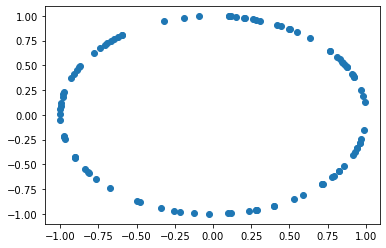

In [211]:
plt.scatter(circle[:,0],circle[:,1])

In [206]:
np.mean(circle,axis=0)

array([-0.00095427,  0.00376853])

In [118]:
covM

array([[[1. , 0.5],
        [0.5, 1. ]],

       [[5. , 0.6],
        [0.6, 7. ]],

       [[4. , 1. ],
        [1. , 2. ]]])

In [124]:
w = np.array([1,2])[:,np.newaxis]

In [125]:
w.T@covM@w

array([[[ 7. ]],

       [[35.4]],

       [[16. ]]])

In [127]:
for i in range(covM.shape[0]):
    print(w.T@covM[i,:,:]@w)

[[7.]]
[[35.4]]
[[16.]]
